## Non-linear feature engineering for Linear Regression

In this notebook, we show that even if linear models are not natively adapted to express a target that is not a linear function of the data, it is still possible to make linear models more expressive by engineering additional features.

A machine learning pipeline that combines a non-linear feature engineering step followed by a linear regression step can therefore be considered a non-linear regression model as a whole.

In this occasion we are not loading a dataset, but creating our own custom data consisting of a single feature. The target is built as a cubic polynomial on said feature. To make things a bit more challenging, we add some random fluctuations to the target.


In [42]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.kernel_approximation import Nystroem

In [3]:
rng = np.random.RandomState(0)

n_sample = 200
data_max, data_min = 1.8, -1.8
len_data = data_max - data_min
# sort the data to make plotting easier later
data = np.sort(rng.rand(n_sample) * len_data - len_data / 2)
noise = rng.randn(n_sample) * 0.4
target = data**3 - 0.6 * data**2 + noise



Tip

np.random.RandomState allows to create a random number generator which can be later used to get deterministic results.

To ease the plotting, we create a pandas dataframe containing the data and target:


In [5]:
full_data = pd.DataFrame({'input_feature': data, 'target': target})

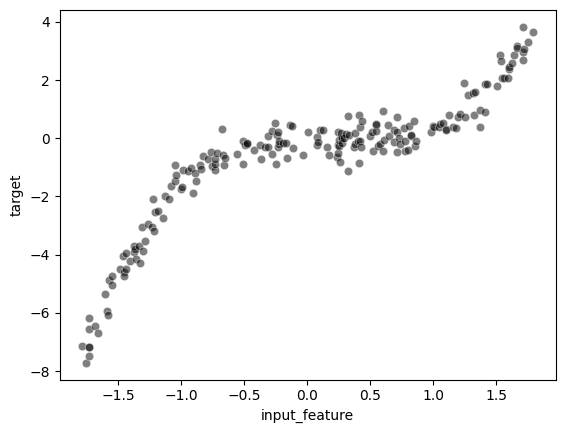

In [7]:
_= sns.scatterplot(data = full_data, x = 'input_feature', y = 'target', color = 'black', alpha = 0.5)



Warning

In scikit-learn, by convention data (also called X in the scikit-learn documentation) should be a 2D matrix of shape (n_samples, n_features). If data is a 1D vector, you need to reshape it into a matrix with a single column if the vector represents a feature or a single row if the vector represents a sample.


In [8]:
# X should be 2D for sklearn: (n_samples, n_features)
data = data.reshape((-1,1))
data.shape

(200, 1)

To avoid writing the same code in multiple places we define a helper function that fits, scores and plots the different regression models.


In [9]:
def fit_score_plot_regression(model, title = None):
  model.fit(data, target)
  target_predicted = model.predict(data)
  mse = mean_squared_error(target, target_predicted)
  ax = sns.scatterplot(data = full_data, x = 'input_feature', y = 'target', color = 'black', alpha = 0.5)
  ax.plot(data, target_predicted)
  if title is not None:
    _= ax.set_title(title + f' (MSE = {mse:.2f})')
  else:
    _= ax.set_title(f'Mean squared error = {mse:.2f}')

In [11]:
# We now observe the limitations of fitting a linear regression model.

linear_regression = LinearRegression()
linear_regression

LinearRegression()

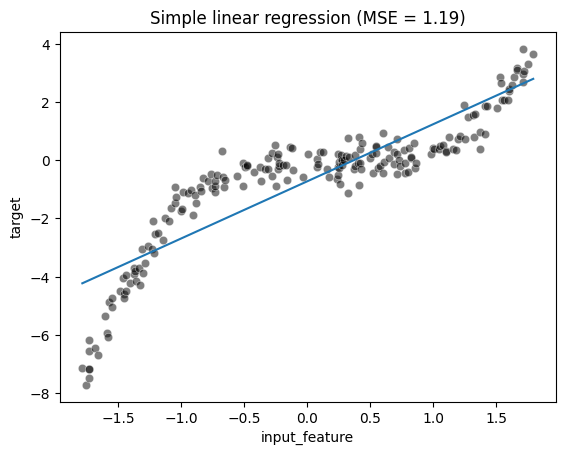

In [14]:
fit_score_plot_regression(linear_regression, title = 'Simple linear regression')

Here the coefficient and intercept learnt by LinearRegression define the best "straight line" that fits the data. We can inspect the coefficients using the attributes of the model learnt as follows:

In [15]:
print(f'wieght: {linear_regression.coef_[0]:.2f},'
      f'intercept: {linear_regression.intercept_:.2f}')

wieght: 1.96,intercept: -0.73


Notice that the learnt model cannot handle the non-linear relationship between data and target because linear models assume a linear relationship. Indeed, there are 3 possibilities to solve this issue:



*   choose a model that can natively deal with non-linearity,
*   engineer a richer set of features by including expert knowledge which can be directly used by a simple linear model, or
*   use a "kernel" to have a locally-based decision function instead of a global linear decision function.

    
    

Let's illustrate quickly the first point by using a decision tree regressor which can natively handle non-linearity.


In [17]:
tree = DecisionTreeRegressor(max_depth = 4).fit(data, target)
tree

DecisionTreeRegressor(max_depth=4)

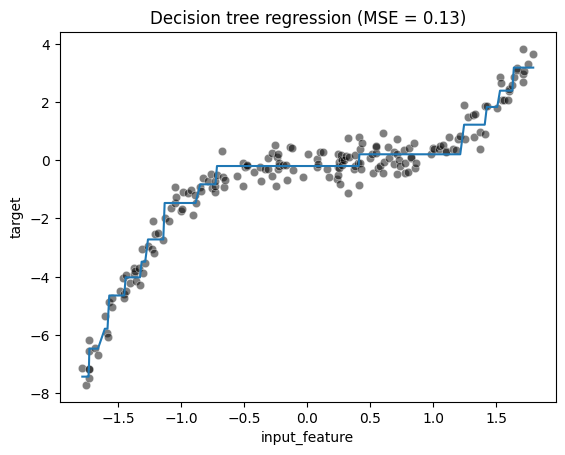

In [18]:
fit_score_plot_regression(tree, title='Decision tree regression')

Instead of having a model which can natively deal with non-linearity, we could also modify our data: we could create new features, derived from the original features, using some expert knowledge. In this example, we know that we have a cubic and squared relationship between data and target (because we generated the data).

Indeed, we could create two new features (data ** 2 and data ** 3) using this information as follows. This kind of transformation is called a polynomial feature expansion:


In [19]:
data.shape

(200, 1)

In [21]:
data_expanded = np.concatenate([data, data**2, data**3], axis = 1)
data_expanded.shape

(200, 3)

Instead of manually creating such polynomial features one could directly use sklearn.preprocessing.PolynomialFeatures.

In [24]:
polynomial_expansion = PolynomialFeatures(degree = 3, include_bias = False)

In the previous cell we had to set include_bias=False as otherwise we would create a constant feature perfectly correlated to the intercept_ introduced by the LinearRegression. We can verify that this procedure is equivalent to creating the features by hand up to numerical error by computing the maximum of the absolute values of the differences between the features generated by both methods and checking that it is close to zero:

np.abs(polynomial_expansion.fit_transform(data) - data_expanded).max()

To demonstrate the use of the PolynomialFeatures class, we use a scikit-learn pipeline which first transforms the features and then fit the regression model.


In [26]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree = 3, include_bias= False),
    LinearRegression(),
)
polynomial_regression

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('linearregression', LinearRegression())])

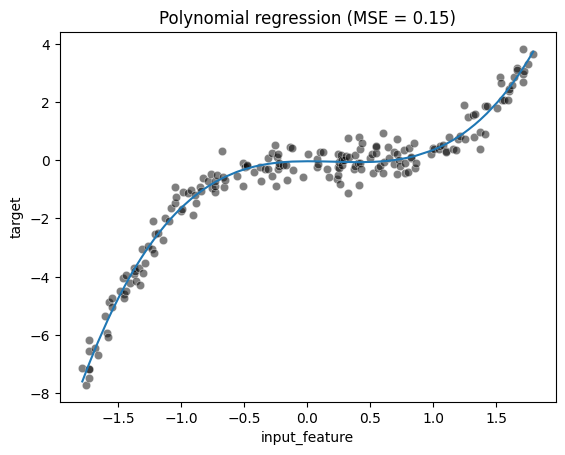

In [27]:
fit_score_plot_regression(polynomial_regression, title = 'Polynomial regression')

We can see that even with a linear model, we can overcome the linearity limitation of the model by adding the non-linear components in the design of additional features. Here, we created new features by knowing the way the target was generated.

The last possibility is to make a linear model more expressive is to use a "kernel". Instead of learning one weight per feature as we previously did, a weight is assigned to each sample. However, not all samples are used: some redundant data points of the training set are assigned a weight of 0 so that they do no influence the model's prediction function. This is the main intuition of the support vector machine algorithm.

The mathematical definition of "kernels" and "support vector machines" is beyond the scope of this course. We encourage interested readers with a mathematical training to have a look at the scikit-learn documentation on SVMs for more details.

For the rest of us, let us just develop some intuitions on the relative expressive power of support vector machines with linear and non-linear kernels by fitting them on the same dataset.

First, consider a support vector machine with a linear kernel:


In [29]:
svr = SVR(kernel = 'linear')
svr

SVR(kernel='linear')

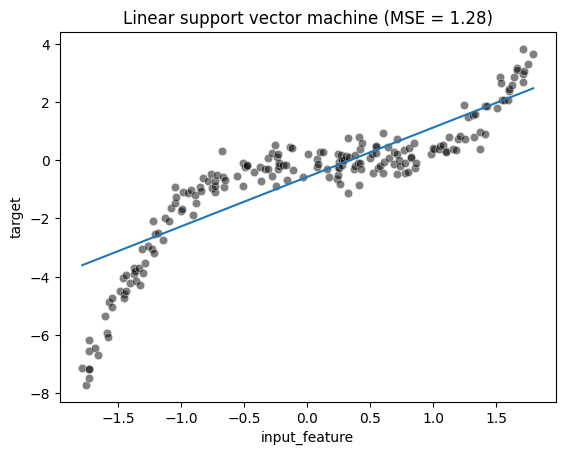

In [30]:
fit_score_plot_regression(svr, title = 'Linear support vector machine')

The predictions of our SVR with a linear kernel are all aligned on a straight line. SVR(kernel="linear") is indeed yet another example of a linear model.

The estimator can also be configured to use a non-linear kernel. Then, it can learn a prediction function that computes non-linear relations between samples for which we want to make a prediction and selected samples from the training set.

The result is another kind of non-linear regression model with a similar expressivity as our previous polynomial regression pipeline:


In [31]:
svr = SVR(kernel = 'poly', degree = 3)
svr

SVR(kernel='poly')

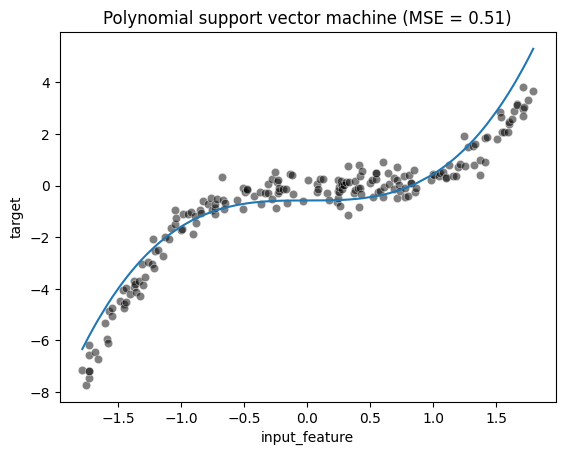

In [32]:
fit_score_plot_regression(svr, title = 'Polynomial support vector machine')

Kernel methods such as SVR are very efficient for small to medium datasets.

For larger datasets with n_samples >> 10_000, it is often computationally more efficient to perform explicit feature expansion using PolynomialFeatures or other non-linear transformers from scikit-learn such as KBinsDiscretizer or SplineTransformer.

Here again we refer the interested reader to the documentation to get a proper definition of those methods. The following just gives an intuitive overview of the predictions we would get using those on our toy dataset:


In [36]:
binned_regression = make_pipeline(
    KBinsDiscretizer(n_bins = 10),
    LinearRegression(),
)
binned_regression

Pipeline(steps=[('kbinsdiscretizer', KBinsDiscretizer(n_bins=10)),
                ('linearregression', LinearRegression())])

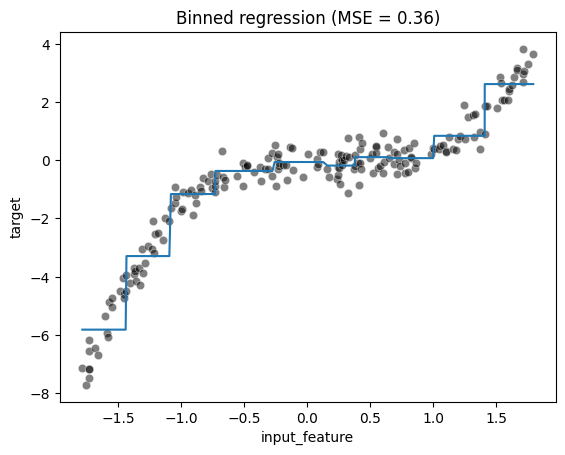

In [37]:
fit_score_plot_regression(binned_regression, title = 'Binned regression')

In [40]:
spline_regression = make_pipeline(
    SplineTransformer(degree = 3, include_bias = False),
    LinearRegression(),
)
spline_regression

Pipeline(steps=[('splinetransformer', SplineTransformer(include_bias=False)),
                ('linearregression', LinearRegression())])

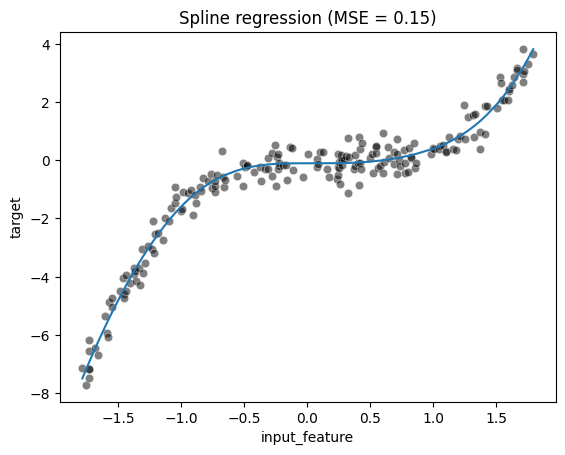

In [41]:
fit_score_plot_regression(spline_regression, title = 'Spline regression')

Nystroem is a nice alternative to PolynomialFeatures that makes it possible to keep the memory usage of the transformed dataset under control. However, interpreting the meaning of the intermediate features can be challenging

In [44]:
nystroem_regression = make_pipeline(
    Nystroem(kernel = 'poly', degree = 3, n_components = 5, random_state = 0),
    LinearRegression(),
)
nystroem_regression

Pipeline(steps=[('nystroem',
                 Nystroem(degree=3, kernel='poly', n_components=5,
                          random_state=0)),
                ('linearregression', LinearRegression())])

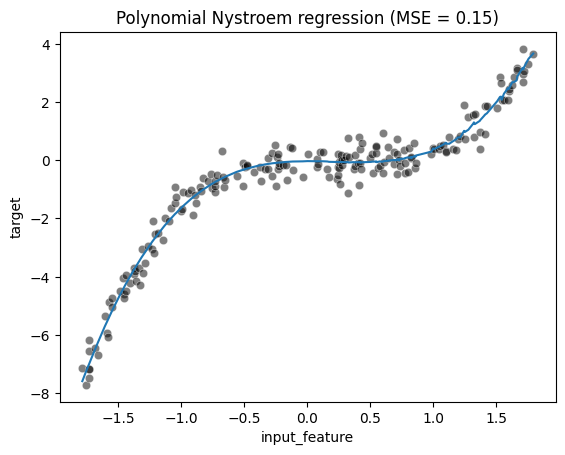

In [45]:
fit_score_plot_regression(nystroem_regression, title='Polynomial Nystroem regression')